# Preprocessing pipeline

Even though Kaggle has worked to collect and ordered the data, the JSON files need some work before becoming trainable dataset

This will be organized in a three step process


P1 ==>
-  We will reduce the number of JSON files we will run on (1 in 100). This is to produce a more managable dataset as we are only testing the waters with our model. The full data can be reprocessed if the model is found to be good.
-  The info in CSVs will be brought in to become columns in panda dataset
-  We will split the dataset into two. One for each type of cell. As it would be easier to build a model predicting just code and just MarkDown. We could then use their output to train our full model

P2 ==>
- Tokens will be created from the markdowns and codes, with slightly different process
- features will be added (length of text, num of lines of code vs comments, dummy variables to replace left values - which should be encoded differently when it's a right value)

P3 ==>
- Vectorize the entry using `skikit-learn`

P4 ==>
- replace order of cells with comparison relations `{ <, =, > }`, creating n(n-1)/2 combinations
- Dataframes/ CSVs will be concatenated


Timing will be mandatory for long steps and recorded for purpose of optimizing re-running strategies




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_json("data/train/00001756c60be8.json")

In [48]:
train_order = pd.read_csv("data/train_orders.csv")
train_order.cell_order=train_order.cell_order.str.split()
train_order.head(5)

,id,cell_order
0,00001756c60be8,"[1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b7..."
1,00015c83e2717b,"[2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c4172..."
2,0001bdd4021779,"[3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310..."
3,0001daf4c2c76d,"[97266564, a898e555, 86605076, 76cc2642, ef279..."
4,0002115f48f982,"[9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe..."


## Step P1: Skim dataset and add order information

In [49]:
%%time
#  time: 5sec / memory: 4MB
for index, row in train_order.iterrows():
    if index%1000==0:
        true_order = { h: i for i, h in enumerate(row["cell_order"])}

        # get dataframe
        df = pd.read_json(f"data/train/{row['id']}.json")
        df.loc[:,"true_order"] = df.index.map(true_order)
        df_code = df[df.cell_type=="code"].copy()
        df_md = df[df.cell_type=="markdown"].copy()
        df_code.loc[:,"true_order_code"] = df_code["true_order"].rank(method="min").map(int)
        df_md.loc[:,"true_order_md"] = df_md["true_order"].rank(method="min").map(int)
        df_code = df_code.sample(frac=1).reset_index(drop=True)
        #df.to_csv(f"data/train_P1/{row['id']}.csv")
        #df.to_json(f"data/train_P1/{row['id']}.json")
        df_code.to_csv(f"data/train_P1_code/{row['id']}.csv")
        df_code.to_json(f"data/train_P1_code/{row['id']}.json")
        df_md.to_csv(f"data/train_P1_md/{row['id']}.csv")
        df_md.to_json(f"data/train_P1_md/{row['id']}.json")
df.sample(5)
        

CPU times: user 1.94 s, sys: 107 ms, total: 2.04 s
Wall time: 2.1 s


,cell_type,source,true_order
5ba7a58e,markdown,# Load data,1
4510d461,code,"pd.pivot_table(train_data,index='Survived',col...",32
79a49773,code,train_data['cabin_adv'] = train_data.Cabin.app...,31
d4d9dc69,code,# see sex against survival\nsns.barplot(x='Sex...,24
50a23c3a,code,"# label encoder will be used for Embarked, nam...",41


## Pipeline decorator

Write a decorator that encapsulates the process of opening files, performing transformations and saving them
This is less efficient in terms of storage, but since I am running on my laptop, this helps save CPU time - You don't need to re-run everything everytime you make a change

In [378]:
import os
from random import shuffle
# this configures and returns the decorator
def pipeline(indir, outdir=None, breakafterone = False):

    # the decorator only receives the function and nothing else
    def pipelinedecor(funct):

        ## this will take the function and run it
        def pipelineinner(df, *args, **kwargs):
            df_ = df
            infiles = os.listdir(indir)

            for f in infiles:

                if os.path.isfile(indir+f):
                    fn_ = f.split(".")

                    
                    if fn_[1]=="json":
                        # df is just a dummy variable 
                        # as we will give it our own input and output
                        
                        df = pd.read_json(indir+ f"{fn_[0]}.json")
                        # main function
  
                        df =  funct(df, *args, **kwargs)

                        if outdir and df is not None:
                            df.to_csv(outdir+ f"{fn_[0]}.csv")  # at this point csv is used for human verification
                            df.to_json(outdir+ f"{fn_[0]}.json")

                        if breakafterone:
                            break

            return df_ # return the dummy variable unchanged
        return pipelineinner  
    return pipelinedecor
    

## Step P2: NLP preprocessing

Markdown is transformed with common NLP preprocessing techniques

lower case, remove html tags (as markdown is html compatible), remove non-alphabetical characters,
remove digits

The markdown is then tokenized and further words are dropped if they are stop words, is digit number (unfortunately this sometimes remove chapter number which would be useful - opportunity for feature engineering), having length more than 20 characters (usually these are hashes)

Lastly the words pass through a stemmer to remove grammatical conjugations which confuses the computer

In [6]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist

extra_stopwords = ["li", "br", "http", "https", "www", "com", "class", "alert"]
re_html = re.compile(r'<[^>]+>')
re_char = re.compile(r"[^a-zA-Z0-9]")
#print(re_html.sub("",r'html_text = "<HTML><HEAD> This is HEAD <INSIDE> The is inside tag </INSIDE></HEAD> <BODY> This is BODY </BODY></HTML>'))

def preprocessing_unit(sourcetext: str):
    words = sourcetext.lower()
    words = re_html.sub('', words)
    #words = re.sub(r"[^a-zA-Z0-9]", " ", words)
    words = re_char.sub(' ', words)
    words=nltk.word_tokenize(words)
    words=[w for w in words if w not in stopwords.words("english") + extra_stopwords]
    words = [w for w in words if not w.isdigit()]
    words = [w for w in words if len(w)<20]
    words = [PorterStemmer().stem(w) for w in words]
    
    
    return words

### AST Unit

The AST unit generates left and right values, which is used in different ways

1. we get a list of variables, which might be replaced by dummy variable for training
2. we may build a directed graph which could help establish inheritance. These are strong features even as some authors of these notebooks are error-prone

In [7]:
import ast
re_nomagic = re.compile(r"^[!%].*\n?", flags=re.MULTILINE) # remove ipython magic (syntax error)

def ast_unit(sourcetext):

    sourcetext =  re_nomagic.sub(" ", sourcetext.lower())
    
    try:
        root = ast.parse(sourcetext)
    except SyntaxError as e: 
        # This is unavoidable as we cannot control what 
        # authors of notebook put into their coding cells
        # and at this point AST dosn't have a good way to 
        # recover from an error
        return ([],[])

    # all use of variables
    all_vars = {node.id for node in ast.walk(root) if isinstance(node, ast.Name)}
    
    # left values
    # currently only direct assignment of simple variables are 
    assignment = {n.id                      for node in ast.walk(root) \
                                            if isinstance(node, ast.Assign) \
                                            for n in node.targets\
                                            if isinstance(n, ast.Name) }


    all_imports =  {n.asname or n.name  for node in ast.walk(root) \
                                    if isinstance(node, (ast.Import, ast.ImportFrom)) \
                                    for n in node.names} 
 
    right_values = all_vars-assignment-all_imports
    left_values = assignment | all_imports
    return list(left_values), list(right_values)

source = "import pandas as pd \nfrom imblearn.over_sampling import "\
         "RandomOverSampler, SMOTE \nimport matplotlib; x = "\
         "train_df.drop(columns = \"target\", random_seed=seed)"
 
ast_unit(source)

(['smote', 'randomoversampler', 'matplotlib', 'x', 'pd'], ['train_df', 'seed'])

In [8]:
testphrase = df1.iloc[-2]["source"]
print(testphrase, " ==> ", preprocessing_unit(testphrase))
testphrase = df.iloc[-2]["source"]
print(testphrase, " ==> ", preprocessing_unit(testphrase))

Инициализация класса Data  ==>  ['data']
So some people are just not paying. Let's not worry about them.  ==>  ['peopl', 'pay', 'let', 'worri']


### Applying transformation
This applies the preprocessing and AST units above

In [117]:
%%time

all_codetokens_in_all_nbs = []
@pipeline("data/train_P1_code/","data/train_P2_code/", breakafterone=False)
def P2_code(df, all_codetokens_in_all_nbs):

    ## AST TREE
    df["codetokens"] = df["source"].apply(ast_unit)

    all_codetokens_in_nb = df["codetokens"].apply(lambda x: x[0]+x[1]).sum()
    df.loc[:, "L-codetokens"] = df.apply(lambda x: x.codetokens[0], axis =1)
    df.loc[:, "R-codetokens"] = df.apply(lambda x: x.codetokens[1], axis =1)


    ## Ordinary text analysis
    df["tokens"] = df["source"] .apply(preprocessing_unit)
    
    all_tokens_in_nb = df["tokens"].apply(lambda words: [w for w in words if w not in stopcodewords]).sum()
    all_codetokens_in_all_nbs += all_codetokens_in_nb

    return df


# 23sec/8MB for 0.1% data
# input/ output is just dummy variable
_ = P2_code(_,      all_codetokens_in_all_nbs)

CPU times: user 22.1 s, sys: 1.53 s, total: 23.7 s
Wall time: 23.9 s


In [119]:
%%time
all_tokens_in_all_nbs = []
@pipeline("data/train_P1_md/","data/train_P2_md/", breakafterone=False)
def P2_md(df, all_tokens_in_all_nbs):
    df["tokens"] = df["source"].apply(preprocessing_unit)
    
    all_tokens_in_nb = df.tokens.apply(lambda x: " ".join(x))
    all_tokens_in_all_nbs += all_tokens_in_nb.tolist()
    return df

#8sec/8MB for 0.1% data
# input/ output is just dummy variable
_ = P2_md("dummy",  all_tokens_in_all_nbs) 

CPU times: user 6.62 s, sys: 537 ms, total: 7.16 s
Wall time: 8.06 s


In [106]:
print(FreqDist(all_tokens_in_all_nbs).most_common(30))

[('', 52), ('tabl content', 23), ('featur engin', 10), ('model', 10), ('import librari', 8), ('predict', 7), ('load data', 7), ('train model', 6), ('import data', 6), ('exploratori data analysi', 6), ('preprocess', 6), ('train', 6), ('conclus', 5), ('miss valu', 4), ('decis tree', 4), ('random forest', 4), ('eda', 4), ('prepar data', 4), ('question', 4), ('featur import', 4), ('correl', 4), ('load', 3), ('scatter plot', 3), ('import modul', 3), ('util function', 3), ('model evalu', 3), ('load dataset', 3), ('data', 3), ('import packag', 3), ('logist regress', 3)]


In [55]:
all_counts = dict()
for size in 1, 2, 3, 4, 5:
    all_counts[size] = FreqDist(ngrams(all_tokens_in_all_nbs, size))
# No Ngrams for code
all_code_counts = FreqDist(all_codetokens_in_all_nbs)

## P2A: Plotting

Now checking the overall frequecy of words

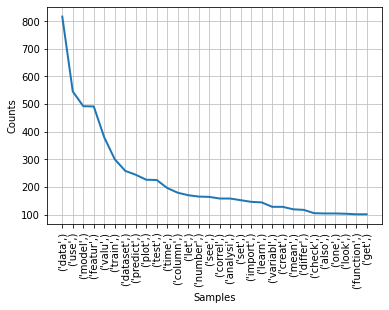

In [56]:
ax = all_counts[1].plot(30)

In [57]:
all_counts[1].most_common(10)

[(('data',), 816),
 (('use',), 545),
 (('model',), 492),
 (('featur',), 491),
 (('valu',), 379),
 (('train',), 300),
 (('dataset',), 258),
 (('predict',), 244),
 (('plot',), 226),
 (('test',), 225)]

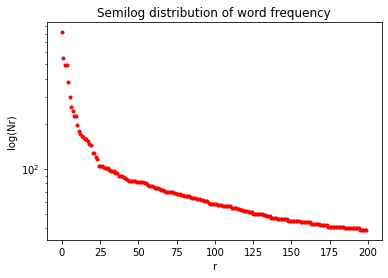

In [58]:
#print( all_counts[1].most_common(30))
log_rvsNr = [(key,value) for((key,), value) in all_counts[1].most_common(200) ]
log_rvsNr = list(zip(*log_rvsNr))

# plot the graph of log(r) vs log(Nr)
plt.semilogy(range(len(log_rvsNr[0])), log_rvsNr[1], 'r.')
plt.xlabel('r')
plt.ylabel('log(Nr)')
#plt.set_xticks(range(len(log_rvsNr[0])))
#plt.set_xticklabels(log_rvsNr[0])
plt.title('Semilog distribution of word frequency')
plt.show()

In [59]:
for ng, ngcount in all_counts[1].most_common(25):
    print(" ".join(ng), ngcount)

data 816
use 545
model 492
featur 491
valu 379
train 300
dataset 258
predict 244
plot 226
test 225
time 196
column 179
let 170
number 165
see 164
correl 158
analysi 158
set 152
import 146
learn 144
variabl 128
creat 128
mean 119
differ 117
check 105


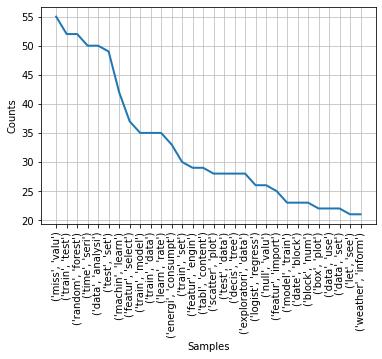

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [60]:
all_counts[2].plot(30)

In [61]:
for size in 2,3:
    for ng, ngcount in all_counts[size].most_common(10):
        print(" ".join(ng), ngcount)

miss valu 55
train test 52
random forest 52
time seri 50
data analysi 50
test set 49
machin learn 42
featur select 37
train model 35
train data 35
exploratori data analysi 27
date block num 23
median hous valu 13
random forest classifi 13
one hot encod 12
target mean date 11
mean date block 11
train test set 10
machin learn model 10
item cnt day 10


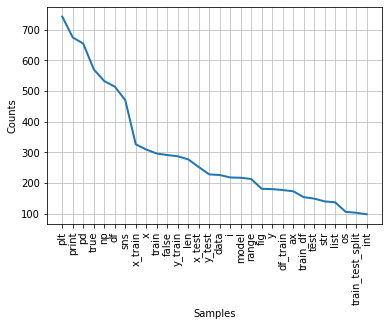

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [62]:
all_code_counts.plot(30)

In [63]:
for ng, ngcount in all_code_counts.most_common(200):
    print(ng, ngcount)

plt 742
print 674
pd 654
true 570
np 532
df 514
sns 470
x_train 326
x 309
train 296
false 291
y_train 287
len 277
x_test 252
y_test 228
data 226
i 218
model 217
range 213
fig 181
y 180
df_train 177
ax 173
train_df 154
test 149
str 140
list 137
os 106
train_test_split 103
int 98
y_pred 98
f 97
df_test 83
accuracy_score 74
_ 70
none 69
confusion_matrix 63
train_data 63
enumerate 62
dict 62
tf 60
col 54
round 54
randomforestclassifier 54
torch 54
filename 52
features 50
df_fe 50
px 49
k 48
test_df 48
logisticregression 47
filenames 45
dirname 45
decisiontreeclassifier 45
dataset 45
datetime 45
batch_size 44
df_house 44
classification_report 42
warnings 42
mean_squared_error 40
standardscaler 40
out 40
epochs 39
tqdm 39
self 39
cross_val_score 39
lr 38
go 38
gridsearchcv 38
y_val 38
history 37
kneighborsclassifier 37
results 37
train_new 37
zip 36
c 36
tweets 36
svc 35
p 34
row 33
metrics 33
dense 32
float 32
df_all 32
n 31
time 31
nn 31
car 31
linearregression 30
cols 30
clf 30
set 30
mcr

## Step P3: Vectorizing

Several options: one-hot encoding, TF-IDF (document defined as cells, as that is the unit we want to measure the )

### An array of all sentences/ lines of code

In [125]:
%%time
## This creates list of sentences for all notebooks so as to be fed into scikit vectorizers

#just a trick to make sure the pipeline produce side-effects
sentences_in_all_nbs = [pd.Series([])]

@pipeline("data/train_P2_md/", None)
def P3A_md(df, sentences_in_all_nbs):

    sentences = df.loc[:, "tokens"].map(lambda x: " ".join(x))
    sentences_in_all_nbs[0] = pd.concat([sentences_in_all_nbs[0], sentences])
    return df

# 0.5 sec for 0.1% data
_ = P3A_md("dummy", sentences_in_all_nbs) 
# input/ output is just dummy variable
sentences_in_all_nbs=sentences_in_all_nbs[0]

<timed exec>:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 488 ms, sys: 12.4 ms, total: 500 ms
Wall time: 515 ms


In [126]:
%%time
codesentences_in_all_nbs = [pd.Series([])]

@pipeline("data/train_P2_code/", None)
def P3A_code(df, codesentences_in_all_nbs):
    codesentences = df.loc[df.codetokens.values != None, "codetokens"]\
                                .map(lambda x: " ".join(x[0]+x[1]))
    codesentences_in_all_nbs[0] = pd.concat([codesentences_in_all_nbs[0], codesentences])
    return df

# 1 sec for 0.1% data
_ = P3A_code("dummy", codesentences_in_all_nbs) 
# input/ output is just dummy variable
codesentences_in_all_nbs = codesentences_in_all_nbs[0]

<timed exec>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


CPU times: user 687 ms, sys: 24.1 ms, total: 712 ms
Wall time: 1.08 s


In [127]:
sentences_in_all_nbs

1bf39149    order work kera data need reshap treat variabl...
7dadab4a                                       import librari
56eb0d3e    let plot temperatur two year time frame see cy...
ab7ca7ea    need appli model get predict undo logarithm tr...
584a0ad5                                            introduct
                                  ...                        
211faf9f                  model build inceptionresnetv2 model
a9cc8670                                         declar class
2d555f1d    thank read kernal till end let know improv com...
43c79d7b                                           import lib
7d1cce52                               date preprocess kernal
Length: 2509, dtype: object

## TF-IDF Vectorizer

Two different vectorizers are used for code and markdown respectively. As code tokens are more repetitive, one-hot coding is used. On the other hand TF-IDF is used for markdown. Note that the unit of document is each markdown cell, as that is the unit we need to measure against.

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfVectorizer

# Now setup TF-IDF vectorizor 

tfidf_vectorizer = TfidfVectorizer(min_df=0.01)
tfidf_vectorizer.fit(sentences_in_all_nbs)

print("length of TF-IDF vector", len(tfidf_vectorizer.get_feature_names_out()))
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names_out(),columns=["idf_weights"]) 
#df_idf.sort_values(by=['idf_weights'])
#print(df_idf.sort_values(by=['idf_weights']))

# try transforming one line
vectors_tfidf = tfidf_vectorizer.transform(sentences_in_all_nbs)


length of TF-IDF vector 217


In [129]:
# One hot vectorizor for code (as they are much more repetitive)
vectorizer_code = CountVectorizer(max_features = 250)
vectors_code = vectorizer_code.fit_transform(codesentences_in_all_nbs)
print("length of code one-hot vector", len(vectorizer_code.get_feature_names_out()))

length of code one-hot vector 250


In [131]:
df = pd.DataFrame(vectors_tfidf[0].T.todense(),
                    index=tfidf_vectorizer.get_feature_names_out(),
                    columns=["TF-IDF"]) 
df.sort_values(by=["TF-IDF"],ascending=False)

,TF-IDF
variabl,0.568352
need,0.323809
sinc,0.271570
model,0.218542
could,0.198576
...,...
hous,0.000000
hyperparamet,0.000000
id,0.000000
imag,0.000000


In [150]:
print("How full is the sparse array?",
      np.count_nonzero(vectors_code.toarray())/vectors_code.shape[0]/vectors_code.shape[1])

How full is the sparse array? 0.01222052205220522


In [145]:
vectors_code 

<4444x250 sparse matrix of type '<class 'numpy.int64'>'
	with 13577 stored elements in Compressed Sparse Row format>

In [146]:
vectors_tfidf

<2509x217 sparse matrix of type '<class 'numpy.float64'>'
	with 12206 stored elements in Compressed Sparse Row format>

### processing

In [190]:
# apped two arrays, we now have double the features
np.append(vectors_code.toarray(),vectors_code.toarray(),axis=1).shape

(4444, 500)

In [193]:
df = pd.read_json("data/train_P2_code/0b1de3720f4773.json")
#df

In [264]:
def add_features(df):
    length = df.tokens.map(len)
    df["length"] = length
add_features(df)
#df

In [183]:
%%time

@pipeline("data/train_P2_code/", "data/train_P3_code/", breakafterone=False)
def P3_code(df):

    # for adding features
    #additional_features = add_features(df)

    vector_code = vectorizer_code.transform(df.tokens.apply(lambda l: " ".join(l)))
    array_code = vector_code.toarray()
    df["encoding"] = array_code.tolist() #+ additional_features
    return df

#df = pd.read_json("data/train_P2_code/0b1de3720f4773.json")
#df = P3_code(df) #FIXME test

# 0.9 sec for 0.1% data
_ = P3_code("dummy") 

CPU times: user 842 ms, sys: 41.7 ms, total: 884 ms
Wall time: 921 ms


In [201]:
%%time

@pipeline("data/train_P2_md/", "data/train_P3_md/", breakafterone=False)
def P3_md(df):

    # for adding features
    #additional_features = add_features(df)

    vector_md = tfidf_vectorizer.transform(df.tokens.apply(lambda l: " ".join(l)))
    array_md = vector_md.toarray()
    df["encoding"] = array_md.tolist() #+ additional_features
    return df

#df = pd.read_json("data/train_P2_md/0b1de3720f4773.json")
#df = P3_md(df) #FIXME test

# 0.9 sec for 0.1% data
_ = P3_md("dummy") 
#df

CPU times: user 837 ms, sys: 55.7 ms, total: 893 ms
Wall time: 935 ms


 ## Step P4: create pairings

We must now pair entries from the same notebook, and add all possible combinations

We also add final set of features that comes out of comparison of any two entries

Ancestry of python variables are now determined solely by comparing L- and R- values

This is both memory and CPU intensive. At current rate, we need 1TB of space if we 

were to process the entire dataset. Ideally we want to optimize this further 


In [ ]:
def ancestry(x):
    ## determine ancestry
    # a variable must first appear as an L value before R value
    # therefore L value should have precedence
    # so if the L value in A appears in B, it suggests A is first 
    # (although there is a chance that this is a typo)
    # This implementation counts the number of times this occur
    x["A_first"] = sum([tok in x["R-codeB"] for tok in x["L-codeA"]])
    x["B_first"] = sum([tok in x["R-codeA"] for tok in x["L-codeB"]])
    return array('f',[x["A_first"], x["B_first"]])

In [339]:
from scipy.sparse import csr_matrix, coo_matrix, hstack, vstack, save_npz
from functools import reduce

In [406]:
%%time
dataset = {"x":[], "y": []}
#@pipeline("data/train_P3_code/", "data/train_P4_code/", breakafterone=False)
@pipeline("data/train_P3_code/", None, breakafterone=False)
def P4_code(df):
    if df.shape[0]==1:
        return None
        
    a, b = map(list, zip(*combinations(df.index, 2)))

    a1 = a+b
    b1 = b+a
    df_new = pd.DataFrame(data={"encodingA":df.loc[a1,"encoding"].reset_index(drop=True),
                                "encodingB":df.loc[b1,"encoding"].reset_index(drop=True),
                                "L-codeA":df.loc[a1,"L-codetokens"].reset_index(drop=True),
                                "R-codeA":df.loc[a1,"R-codetokens"].reset_index(drop=True),
                                "L-codeB":df.loc[b1,"L-codetokens"].reset_index(drop=True),
                                "R-codeB":df.loc[b1,"R-codetokens"].reset_index(drop=True),
                                "true_order_codeA":df.loc[a1,"true_order_code"].reset_index(drop=True),
                                "true_order_codeB":df.loc[b1,"true_order_code"].reset_index(drop=True),})

    df_new.loc[:,"combined_encoding"] = df_new.apply(lambda x: np.append(x.encodingA, x.encodingB), axis=1)
    dataset["x"].extend( df_new.loc[:,"combined_encoding"].tolist() )


    ## adding ancestry information
    df_new.loc[:,"combined_encoding"] = df_new.apply( \
                                        lambda x: np.append(x["combined_encoding"], ancestry(x)),axis=1)
    df_new["result"] = df_new["true_order_codeA"]<df_new["true_order_codeB"] # is A smaller than B
    dataset["y"].extend(df_new["result"].to_list())

    df_new = df_new.drop([   "encodingA",    "encodingB",
                        "L-codeA",      "L-codeB", 
                        "R-codeB",      "R-codeA",
                        "true_order_codeA",   "true_order_codeB"], axis=1)
    return df_new

# 15 mins/ 0.8GB for 0.1% data
# 2mins without writing json
_ = P4_code("dummy") 

dataset["x"] = csr_matrix(dataset["x"])
dataset["y"] = np.array(dataset["y"])
np.save("data/train_P4_code.npy",  dataset["y"])
#yy = np.load("data/train_P4_code.npy")
save_npz("data/train_P4_code_X.npz", dataset["x"])

CPU times: user 2min 33s, sys: 1.76 s, total: 2min 34s
Wall time: 2min 36s


In [403]:



A = csr_matrix([[1, 2], [3, 4]])
B = csr_matrix([[5], [6]])
hstack([A,B])

<2x3 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [405]:
%%time


df = pd.read_json("data/train_P3_md/ed44e2d85b6003.json")
dataset = {"x":[], "y": []}
#@pipeline("data/train_P3_md/", "data/train_P4_md/", breakafterone=True)
@pipeline("data/train_P3_md/",  None, breakafterone=False) 
def P4_md(df, dataset):

    if df.shape[0]==1:
        return None

    a, b = map(list, zip(*combinations(df.index, 2)))

    a1 = a+b
    b1 = b+a
    df_new = pd.DataFrame( data={"encodingA":df.loc[a1,"encoding"].reset_index(drop=True),
                                "encodingB":df.loc[b1,"encoding"].reset_index(drop=True),
                                "true_order_mdA":df.loc[a1,"true_order_md"].reset_index(drop=True),
                                "true_order_mdB":df.loc[b1,"true_order_md"].reset_index(drop=True),} )

    df_new.loc[:,"combined_encoding"] = df_new.apply(lambda x: np.append(x.encodingA, x.encodingB), axis=1)

    dataset["x"].extend( df_new.loc[:,"combined_encoding"].tolist() )



    df_new["result"] = df_new["true_order_mdA"]<df_new["true_order_mdB"] # is A smaller than B
    dataset["y"].extend(df_new["result"].to_list())

    df_new = df_new.drop([  "encodingA",    "encodingB",
                            "true_order_mdA",   "true_order_mdB"], axis=1)
    return df_new

# 8 mins/ 500MB for 0.1% data
# 6 sec if no writing to disk
_ = P4_md("dummy", dataset) 

dataset["x"] = csr_matrix(dataset["x"])
dataset["y"] = np.array(dataset["y"])
np.save("data/train_P4_md.npy",  dataset["y"])
#yy = np.load("data/train_P4_md.npy")
save_npz("data/train_P4_md_X.npz", dataset["x"])

CPU times: user 5.15 s, sys: 317 ms, total: 5.46 s
Wall time: 5.9 s


## References

Berkeley Stat 157: Word2vec demonstration

https://nbviewer.org/url/courses.d2l.ai/berkeley-stat-157/slides/4_18/word2vec-gluon.ipynb

Applied Text Analysis with Python by Benjamin Bengfort, Rebecca Bilbro, Tony Ojeda

Chapter 4. Text Vectorization and Transformation Pipelines

https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html

apply(), applymap(), map() in Pandas

https://towardsdatascience.com/introduction-to-pandas-apply-applymap-and-map-5d3e044e93ff

In [ ]:
%%time
df = pd.read_json("data/train_P3_code/0b1de3720f4773.json")
#print(df.index.shape)

from itertools import combinations, combinations_with_replacement
from array import array

a, b = map(list, zip(*combinations(df.index, 2)))
#print(len(a))

a1 =a+b
b1 = b+a
df_new = pd.DataFrame(data={"encodingA":df.loc[a1,"encoding"].reset_index(drop=True),
 "encodingB":df.loc[b1,"encoding"].reset_index(drop=True),
 "L-codeA":df.loc[a1,"L-codetokens"].reset_index(drop=True),
 "R-codeA":df.loc[a1,"R-codetokens"].reset_index(drop=True),
 "L-codeB":df.loc[b1,"L-codetokens"].reset_index(drop=True),
 "R-codeB":df.loc[b1,"R-codetokens"].reset_index(drop=True),
 "true_order_codeA":df.loc[a1,"true_order_code"].reset_index(drop=True),
 "true_order_codeB":df.loc[b1,"true_order_code"].reset_index(drop=True),})

df_new.loc[:,"combined_encoding"] = df_new.apply(lambda x: np.append(x.encodingA, x.encodingB), axis=1)
print(df_new.loc[1,"combined_encoding"].shape)

## adding ancestry information
df_new.loc[:,"combined_encoding"] = df_new.apply( \
                                    lambda x: np.append(x["combined_encoding"], ancestry(x)),axis=1)

# generate ground truth value to be fitted on
df_new["result"] = df_new["true_order_codeA"]<df_new["true_order_codeB"] # is A smaller than B
df_new = df_new.drop([   "encodingA",    "encodingB",
                "L-codeA",      "L-codeB", 
                "R-codeB",      "R-codeA",
                "source",       "cell_type",
                "true_order",   "true_order_code"], axis=1)
                
# should be 502 = (250)*2 + 2
print(df_new.loc[1,"combined_encoding"].shape)

df_new

(500,)
(502,)
CPU times: user 7.86 s, sys: 233 ms, total: 8.09 s
Wall time: 8.95 s


,encodingA,encodingB,L-codeA,R-codeA,L-codeB,R-codeB,true_order_codeA,true_order_codeB,combined_encoding,result
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[model, preds, grid_search_params]","[lgb, train_features, roc_auc_score, print, te...",[train_labels_last],[app_train],21,43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[model, preds, grid_search_params]","[lgb, train_features, roc_auc_score, print, te...",[],"[objective, params, iteration, print, default_...",21,88,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[model, preds, grid_search_params]","[lgb, train_features, roc_auc_score, print, te...",[],[manual_features_test],21,59,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[model, preds, grid_search_params]","[lgb, train_features, roc_auc_score, print, te...",[submission],"[test_ids, preds, false, pd]",21,32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[model, preds, grid_search_params]","[lgb, train_features, roc_auc_score, print, te...","[app_train, app_test]","[print, pd]",21,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
...,...,...,...,...,...,...,...,...,...,...
12205,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[os, np, plt, labelencoder, warnings, sns, pd]",[],"[test_set, train_set]","[lgb, train_features, train_labels, test_featu...",1,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
12206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[test_set, train_set]","[lgb, train_features, train_labels, test_featu...",102,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
12207,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[os, np, plt, labelencoder, warnings, sns, pd]",[],"[eval_results, hyperparameters, itertools, res...","[objective, list, dict, v, values, zip, range,...",1,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",True
12208,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[eval_results, hyperparameters, itertools, res...","[objective, list, dict, v, values, zip, range,...",102,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",False
